In [ ]:
!pip install xlrd

# Modules for data processing
import pandas as pd
import numpy as np
import os
import re
import sys
from datetime import datetime
import calendar

import warnings
warnings.filterwarnings("ignore")

# REFERENCE: https://www.kaggle.com/dmitryuarov/eda-covid-19-impact-on-digital-learning
STATE_ABBR = {
    'Alabama': 'AL', 'Alaska': 'AK', 'American Samoa': 'AS', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'District of Columbia': 'DC', 'District Of Columbia': 'DC',
    'Florida': 'FL', 'Georgia': 'GA', 'Guam': 'GU', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL',
    'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME',
    'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH',
    'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND',
    'Northern Mariana Islands':'MP', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA',
    'Puerto Rico': 'PR', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN',
    'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virgin Islands': 'VI', 'Virginia': 'VA', 'Washington': 'WA',
    'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}
STATE_NAME = dict([(y, x) for x, y in STATE_ABBR.items()])

# ########################################################################
# ### analyze_dataset
# ########################################################################
# #
# # Simple function to help quickly analyze information & usability of
# # a dataset. Provides information about shape, null values, unique
# # values & basic statistical features.
# #
# # Inputs:
# #   1.  df_path (string) -> Dataset path (if available)
# #   2.  df (pandas dataframe) -> Dataset (if available)
# #   3.  direct_df (boolean) -> Whether dataset path or dataset is
# #       being provided
# #   4.  processing_func (function) -> If dataset needs to be processed
# #       before analyzing
# #   5.  Other arguments for pd.read_csv(...) if dataset path is being
# #       provided
# #
# # Return:   Either dataframe itself (if path provided) or head of
# #           dataframe (if dataframe provided)
# #
# ########################################################################

# def analyze_dataset(df_path = None, df = None, direct_df = False, processing_func = lambda x: x, **read_csv_args):
    
#     if(direct_df == False):
#         df = pd.read_csv(df_path, **read_csv_args)
#     df = processing_func(df)
    
#     num_rows, num_cols = df.shape
#     dtypes = dict(df.dtypes.items())
#     print("*****************")
#     print("Basic Info:")
#     print("*****************\n")
#     print(f"Shape of Dataset: {num_rows} rows, {num_cols} cols")
#     print("Columns:")
#     for col_idx, col in enumerate(df.columns):
#         print(f"\t{col_idx+1}. {col}\n\t\t\t\t\t\t\t\t{dtypes[col]}")
    
#     print("\n\n\n*****************")
#     print("Null Values:")
#     print("*****************\n")
#     nulls = pd.isnull(df).sum()
#     print(f"Total Nulls: {nulls.sum()}")
#     nulls = nulls[nulls > 0]
#     nulls = list(sorted(nulls.items(), key = lambda x: x[1], reverse = True))
#     print("Columns with missing values:")
#     for col_idx, (col_name, col_missin_num) in enumerate(nulls):
#         print(f"\t{col_idx + 1}. {col_name}\n\t\t\t\t\t\t\t\t{col_missin_num} missing ({col_missin_num / num_rows * 100:.1f}%)")
    
#     print("\n\n\n*****************")
#     print("Column-specific:")
#     print("*****************\n")
#     print("Unique values in columns:")
#     idx = 1
#     for col in df.columns:
#         nunique = df[col].nunique()
#         if(nunique < 10):
#             unique_vals = ["'" + str(x) + "'" for x in df[col].unique()]
#             print(f"{idx}. {col} has {nunique} unique values")
#             idx += 1
#             print(f"\t[ {', '.join(unique_vals)} ]")
#     print("\n\nStatistical Features:")
#     print(df.describe())
    
#     print("\n\n")
#     if(direct_df == True):
#         return df.head()
#     else:
#         return df

########################################################################
### load_main_dataset
########################################################################
#
# Function to load the main processed & merged dataset for
# engagement. Has options to merge selected datasets. The processing
# has been done separately in another function `process_main_dataset`
#
# Inputs:
#   1.  whether_merge_district (boolean) -> Whether to merge districts
#       data
#   2.  whether_merge_products (boolean) -> Whether to merge products
#       data
#   3.  whether_merge_dates (boolean) -> Whether to merge dates data
#
# Return:   Engagement data merged with other relevant datasets
#
########################################################################

def load_main_dataset(whether_merge_districts = True, whether_merge_products = True, whether_merge_dates = True):
    def reduce_dtype_size(df):
        numeric_cols = [x for x in df.columns if (df[x].dtype != object) & ('datetime' not in str(df[x].dtype))]
        for numeric_col in numeric_cols:
            if('float' in str(df[numeric_col].dtype)):
                df[numeric_col] = pd.to_numeric(df[numeric_col], downcast = 'float')
            elif(('uint' in str(df[numeric_col].dtype)) | ('bool' in str(df[numeric_col].dtype))):
                df[numeric_col] = pd.to_numeric(df[numeric_col], downcast = 'unsigned')
            else:
                df[numeric_col] = pd.to_numeric(df[numeric_col], downcast = 'signed')
        return df
    
    def merge_districts_data(engagement_data):
        districts_data = pd.read_csv('/kaggle/input/learnplatform-analysis-data/districts_data.csv')
        districts_data = reduce_dtype_size(districts_data)
        merged_engagement_data = pd.merge(engagement_data, districts_data, how = 'left', on = 'district_id')
        return merged_engagement_data

    def merge_products_data(engagement_data):
        products_data = pd.read_csv('/kaggle/input/learnplatform-analysis-data/products_data.csv')
        products_data = reduce_dtype_size(products_data)
        merged_engagement_data = pd.merge(engagement_data, products_data, how = 'left', left_on = 'lp_id', right_on = 'LP ID')
        merged_engagement_data = merged_engagement_data.drop('LP ID', axis = 1)
        return merged_engagement_data

    def merge_dates_data(engagement_data):
        dates_data = pd.read_csv('/kaggle/input/learnplatform-analysis-data/dates_data.csv', parse_dates = ['date'])
        dates_data = reduce_dtype_size(dates_data)
        merged_engagement_data = pd.merge(engagement_data, dates_data, how = 'left', left_on = 'time', right_on = 'date')
        merged_engagement_data = merged_engagement_data.drop('date', axis = 1)
        return merged_engagement_data

    engagement_data = pd.read_csv('/kaggle/input/learnplatform-analysis-data/engagement_data.csv', parse_dates = ['time'])
    engagement_data = reduce_dtype_size(engagement_data)
    if(whether_merge_districts == True):
        engagement_data = merge_districts_data(engagement_data)
    if(whether_merge_products == True):
        engagement_data = merge_products_data(engagement_data)
    if(whether_merge_dates == True):
        engagement_data = merge_dates_data(engagement_data)
    
    return engagement_data


# ########################################################################
# ### process_main_dataset
# ########################################################################
# #
# # Function to process the main processed & save it for
# # loading later from another function `load_main_dataset`.
# #
# # Inputs:
# #   1.  whether_load_url_html_data (boolean) -> Whether to process
# #       and save URL's HTML data
# #
# # Return:   None
# #
# ########################################################################

# def process_main_dataset(whether_load_url_html_data = False):
#     def get_all_na_idx(df):
#         all_na_idx = df.isnull().all(axis=1)
#         return all_na_idx[all_na_idx == True].keys()

#     def add_dummys(df, dummy_cols, remove_orig_dummy_cols = False):
#         dummy_df = df[dummy_cols]
#         dummy_df = pd.get_dummies(dummy_df)
        
#         df = pd.concat([df, dummy_df], axis = 1)
#         if(remove_orig_dummy_cols == True):
#             df = df.drop(dummy_cols, axis = 1)
        
#         return df

#     def reduce_dtype_size(df):
#         numeric_cols = [x for x in df.columns if (df[x].dtype != object) & ('datetime' not in str(df[x].dtype))]
#         for numeric_col in numeric_cols:
#             if('float' in str(df[numeric_col].dtype)):
#                 df[numeric_col] = pd.to_numeric(df[numeric_col], downcast = 'float')
#             elif(('uint' in str(df[numeric_col].dtype)) | ('bool' in str(df[numeric_col].dtype))):
#                 df[numeric_col] = pd.to_numeric(df[numeric_col], downcast = 'unsigned')
#             else:
#                 df[numeric_col] = pd.to_numeric(df[numeric_col], downcast = 'signed')
#         return df
    
#     def load_districts_data():
        
#         def districts_data_preprocessing(districts_data):
            
#             def process_lower_upper_bounds(df_series):
#                 processed_lower_series = []
#                 processed_upper_series = []
                
#                 for row in df_series:                
#                     if(pd.isnull(row) == True):
#                         processed_lower_series.append(row)
#                         processed_upper_series.append(row)
#                     else:
#                         assert(len(row[1:-1].split(', ')) == 2)
#                         lower_val, upper_val = row[1:-1].split(', ')
#                         lower_val = float(lower_val)
#                         upper_val = float(upper_val)
#                         processed_lower_series.append(lower_val)
#                         processed_upper_series.append(upper_val)
                
#                 return processed_lower_series, processed_upper_series
            
#             for col in ['pct_black/hispanic', 'pct_free/reduced', 'county_connections_ratio', 'pp_total_raw']:
#                 lower_series, upper_series = process_lower_upper_bounds(districts_data[col])
#                 districts_data[col + '_lower_bound'] = pd.Series(lower_series, index = districts_data.index)
#                 districts_data[col + '_upper_bound'] = pd.Series(upper_series, index = districts_data.index)
#                 districts_data[col + '_bound_avg'] = pd.Series(np.add(lower_series, upper_series) / 2.0, index = districts_data.index)
            
#             districts_data = districts_data.drop(['pct_black/hispanic', 'pct_free/reduced', 'county_connections_ratio', 'pp_total_raw'], axis = 1)
#             return districts_data
        
#         districts_data = pd.read_csv('/kaggle/input/learnplatform-covid19-impact-on-digital-learning/districts_info.csv')
        
#         districts_data = districts_data_preprocessing(districts_data)
#         districts_data = districts_data.drop(get_all_na_idx(districts_data.drop('district_id', axis = 1))).reset_index(drop = True)
#         districts_data = add_dummys(districts_data, ['locale'], remove_orig_dummy_cols = False)
        
#         #all_states = districts_data['state'].unique()
#         #district_id_state_map = dict(districts_data[['district_id', 'state']].values)
#         #state_district_id_map = dict([(x, [y for y in district_id_state_map if district_id_state_map[y] == x]) for x in all_states])
#         #districts_data = districts_data.drop('state', axis = 1)
        
#         districts_data = reduce_dtype_size(districts_data)
#         return districts_data

#     districts_data = load_districts_data()
    
#     # URL Information Extraction
#     #   For July 2021
#     #   Using similarweb.com
#     #   Avg Duration - in seconds
#     #   Total Visits - in 1000s
#     def load_url_html_data():
#         url_html_dict = {}

#         all_html_content = ""
#         with open(f'./Data/url_info/combined_url_info_data.txt', 'r') as html_file:
#             all_html_content = html_file.read()

#         tot_num_files = len([x for x in all_html_content.split('---') if len(x.strip()) != 0])
#         print(f"Total No. of files: {tot_num_files}\n\n")

#         for html_content_idx, html_content in enumerate(all_html_content.split('---')):
            
#             html_content = html_content.strip()
#             if(len(html_content) == 0):
#                 print("ERROR: URL not found")
#                 sys.exit("")
            
#             url_name = html_content.split('<')[0].strip()
#             html_content = '<'.join(html_content.split('<')[1:])
#             print(f"{html_content_idx + 1}. File: {url_name}\n")
#             if(url_name in url_html_dict):
#                 print("ERROR: Name already exists")
#                 sys.exit("")
#             url_html_dict[url_name] = {}
            
#             # Global Rank
#             global_rank = re.findall('\"GlobalRank":\[\d+,\d+,-?\d+,\d+\]', html_content)
#             if(len(global_rank) != 1):
#                 print("ERROR: Global Rank")
#                 print(global_rank)
#                 sys.exit("")
#             global_rank = int(global_rank[0].split('[')[1].split(',')[0])
#             url_html_dict[url_name]['global_rank'] = global_rank

#             # Country
#             if('<img class="websiteRanks-titleIconImg" src="/images/flags-svg/flag-icon-us.svg">' in html_content):
#                 country = 'USA'
#             else:
#                 print("Country: Not USA!")
#                 country = 'Not_USA'
#             url_html_dict[url_name]['country'] = country
            
#             # Country Rank
#             country_rank = re.findall('\"CountryRanks":\{"\d+":\[\d+,\d+,-?\d+,\d+\]\}', html_content)
#             if(len(country_rank) != 1):
#                 print("ERROR: Country Rank")
#                 print(country_rank)
#                 sys.exit("")
#             country_rank = int(country_rank[0].split('[')[1].split(',')[0])
#             url_html_dict[url_name]['country_rank'] = country_rank
            
#             # Category
#             category = re.findall('<a class="websiteRanks-nameText" data-analytics-category="Internal Link" data-analytics-label="Category Rank/.+" href="/top-websites/category/.+" itemprop="significantLink">.+</a>', html_content)
#             if(len(category) != 1):
#                 print("ERROR: Category")
#                 print(category)
#                 url_html_dict[url_name]['main_category'] = np.nan
#                 url_html_dict[url_name]['sub_category'] = np.nan
#             else:
#                 category = category[0].split('Category Rank/')[1].split('"')[0]
#                 main_category = category.split('/')[0]
#                 url_html_dict[url_name]['main_category'] = main_category
#                 if(len(category.split('/')) != 1):
#                     sub_category = category.split('/')[-1]
#                 else:
#                     sub_category = ""
#                 url_html_dict[url_name]['sub_category'] = sub_category

#             # Category Rank
#             category_rank = re.findall('\"CategoryRank\":\[\d+,\d+,-?\d+,\d+\]', html_content)
#             if(len(category_rank) != 1):
#                 print("ERROR: Category Rank")
#                 print(category_rank)
#                 sys.exit("")
#             category_rank = int(category_rank[0].split('[')[1].split(',')[0])
#             url_html_dict[url_name]['category_rank'] = category_rank

#             # Total Visits
#             total_visits = re.findall('<span class="engagementInfo-valueNumber js-countValue">.*\d+[KMB]</span>', html_content)
#             if(len(total_visits) != 1):
#                 print("ERROR: Total Visits")
#                 print(total_visits)
#                 url_html_dict[url_name]['total_visits'] = np.nan
#             else:
#                 total_visits = total_visits[0].split('>')[1].split('<')[0]
#                 units = total_visits[-1]
#                 total_visits = float(''.join([x for x in total_visits if x.isdigit()]))
#                 if(units == 'K'):
#                     total_visits = total_visits * 1
#                 elif(units == 'M'):
#                     total_visits = total_visits * 1000
#                 elif(units == 'B'):
#                     total_visits = total_visits * 1000000
#                 url_html_dict[url_name]['total_visits'] = total_visits

#             # Avg Duration
#             avg_duration = re.findall('<span class="engagementInfo-valueNumber js-countValue">\d+:\d+:\d+</span>', html_content)
#             if(len(avg_duration) != 1):
#                 print("ERROR: Avg Duration")
#                 print(avg_duration)
#                 url_html_dict[url_name]['avg_duration'] = np.nan
#             else:
#                 avg_duration = avg_duration[0].split('>')[1].split('<')[0]
#                 hr_val, min_val, sec_val = avg_duration.split(':')
#                 avg_duration = 3600 * int(hr_val) + 60 * int(min_val) + int(sec_val)
#                 url_html_dict[url_name]['avg_duration'] = avg_duration

#             # Page Visits
#             page_visits = re.findall('<span class="engagementInfo-valueNumber js-countValue">\d+\.\d+</span>', html_content)
#             if(len(page_visits) != 1):
#                 print("ERROR: Page Visits")
#                 print(page_visits)
#                 url_html_dict[url_name]['page_visits'] = np.nan
#             else:
#                 page_visits = float(page_visits[0].split('>')[1].split('<')[0])
#                 url_html_dict[url_name]['page_visits'] = page_visits

#             # Bounce Rate
#             bounce_rate = re.findall('<span class="engagementInfo-valueNumber js-countValue">\d+.\d+%</span>', html_content)
#             if(len(bounce_rate) != 1):
#                 print("ERROR: Bounce Rate")
#                 print(bounce_rate)
#                 url_html_dict[url_name]['bounce_rate'] = np.nan
#             else:
#                 bounce_rate = float(bounce_rate[0].split('>')[1].split('%')[0])
#                 url_html_dict[url_name]['bounce_rate'] = bounce_rate
            
#             # Description
#             description = re.findall('<p itemprop="description" class="websiteHeader-companyDescription js-companyDescription">.+</p>', html_content)
#             if(len(description) != 1):
#                 url_html_dict[url_name]['description'] = np.nan
#             else:
#                 description = description[0].split('>')[1].split('<')[0]
#                 url_html_dict[url_name]['description'] = description

#         url_html_df = pd.DataFrame.from_dict(url_html_dict, orient = 'index').reset_index(drop = False)
#         url_html_df.columns = ['URL'] + [*url_html_df.columns][1:]

#         url_html_df['global_rank'] = url_html_df['global_rank'].replace({0: np.nan})
#         url_html_df['country_rank'] = url_html_df['country_rank'].replace({0: np.nan})
#         url_html_df['category_rank'] = url_html_df['category_rank'].replace({0: np.nan})

#         additional_data = pd.read_csv('./Data/url_info/url_info_mobile.csv')
#         url_html_df = pd.concat([url_html_df, additional_data], axis = 0)

#         def find_subpage_level(url):
#             level = url.split('://')[1]
#             level = level.split('/')
#             level = [x for x in level if len(x.strip()) > 0]
#             return len(level) - 1
#         url_html_df['URL_subpage_level'] = url_html_df['URL'].apply(find_subpage_level)
#         url_html_df['URL_subpage_visits'] = url_html_df.apply(lambda x: x['total_visits'] * (((100 - x['bounce_rate']) / 100) ** x['URL_subpage_level']), axis = 1)
#         url_html_df['URL_page_duration'] = url_html_df['avg_duration'] / url_html_df['page_visits']
#         url_html_df['URL_subpage_total_browsing_days'] = url_html_df['URL_subpage_visits'] * url_html_df['URL_page_duration'] / 60 / 60 / 24
#         url_html_df['URL_subpage_avg_browsing_days'] = url_html_df['URL_subpage_total_browsing_days'] / 31
#         url_html_df.to_csv('./Data/url_info/final_url_data.csv', index = False)
    
#     def load_products_data():
    
#         def products_data_preprocessing(products_data):

#             products_data['Primary Category'] = products_data['Primary Essential Function'].apply(lambda x: x.split(' - ')[0] if pd.isna(x) == False else np.nan)
#             products_data['Primary Category'] = products_data['Primary Category'].map({'LC': 'LC', 'CM': 'CM', 'SDO': 'SDO', 'LC/CM/SDO': 'Other'})
#             products_data['Primary Essential Function'] = products_data['Primary Essential Function'].apply(lambda x: x.split(' - ')[1] if pd.isna(x) == False else np.nan)
            
#             def sector_map(sectors):
                
#                 sector_prek12 = []
#                 sector_higher_ed = []
#                 sector_corporate = []
                
#                 for sector in sectors:
#                     if(pd.isna(sector) == True):
#                         sector_prek12.append(0)
#                         sector_higher_ed.append(0)
#                         sector_corporate.append(0)
#                     elif(sector == 'PreK-12'):
#                         sector_prek12.append(1)
#                         sector_higher_ed.append(0)
#                         sector_corporate.append(0)
#                     elif(sector == 'PreK-12; Higher Ed'):
#                         sector_prek12.append(1)
#                         sector_higher_ed.append(1)
#                         sector_corporate.append(0)
#                     elif(sector == 'PreK-12; Higher Ed; Corporate'):
#                         sector_prek12.append(1)
#                         sector_higher_ed.append(1)
#                         sector_corporate.append(1)
#                     elif(sector == 'Corporate'):
#                         sector_prek12.append(0)
#                         sector_higher_ed.append(0)
#                         sector_corporate.append(1)
#                     elif(sector == 'Higher Ed; Corporate'):
#                         sector_prek12.append(0)
#                         sector_higher_ed.append(1)
#                         sector_corporate.append(1)
#                     else:
#                         print(f"***\nUnknown sector detected! {sector}\n***")
                
#                 return sector_prek12, sector_higher_ed, sector_corporate
            
#             sector_prek12, sector_higher_ed, sector_corporate = sector_map(products_data['Sector(s)'])
#             products_data = products_data.assign(Sector_prek12 = sector_prek12)
#             products_data = products_data.assign(Sector_higher_ed = sector_higher_ed)
#             products_data = products_data.assign(Sector_corporate = sector_corporate)
            
#             products_data['Primary Essential Function'] = products_data['Primary Essential Function'].replace({"Sites, Resources & References": "Sites, Resources & Reference"})
            
#             # Correcting small mistakes
#             products_data['URL'] = products_data['URL'].replace({'https://fligprid.com': 'https://flipgrid.com'})

#             if(whether_load_url_html_data == True):
#                 load_url_html_data()
#             url_info_data = pd.read_csv('./Data/url_info/final_url_data.csv')
#             url_info_data.columns = ['mainURL_' + x if x != 'URL' else x for x in url_info_data.columns]
#             products_data = pd.merge(products_data, url_info_data, how = 'left', on = 'URL')
            
#             products_data['mainURL_country_rank'] = products_data.apply(lambda x: x if x['mainURL_country'] == 'USA' else np.nan, axis = 1)
            
#             return products_data
        
#         products_data = pd.read_csv('./Data/learnplatform-covid19-impact-on-digital-learning/products_info.csv')
        
#         products_data = products_data_preprocessing(products_data)
#         products_data = add_dummys(products_data, ['Sector(s)', 'Primary Category', 'Primary Essential Function', 'mainURL_main_category'], remove_orig_dummy_cols = False)
        
#         products_data = reduce_dtype_size(products_data)
#         return products_data

#     products_data = load_products_data()

#     # Not focusing on vacation dates since time-analysis is not priority

#     def load_dates_data():
#         days_2020 = pd.date_range(datetime(2020, 1, 1), datetime(2020, 12, 31))
#         dates_data = pd.DataFrame.from_dict({'date': days_2020})
        
#         dates_data['month'] = dates_data['date'].apply(lambda x: x.month)
#         dates_data['day'] = dates_data['date'].apply(lambda x: x.day)
#         dates_data['day_of_week'] = dates_data['date'].apply(lambda x: calendar.day_name[x.weekday()])
#         dates_data['is_weekend'] = dates_data['day_of_week'].apply(lambda x: 1 if (x == 'Saturday') | (x == 'Sunday') else 0)
        
#         us_holidays = pd.read_csv('./Data/US Holiday Dates (2004-2021).csv', usecols = ['Date', 'Holiday'], parse_dates = ['Date'])
#         dates_data = pd.merge(dates_data, us_holidays, how = 'left', left_on = 'date', right_on = 'Date')
#         dates_data = dates_data.drop('Date', axis = 1)
#         dates_data['is_holiday'] = dates_data['Holiday'].apply(lambda x: 0 if pd.isnull(x) == True else 1)
        
#         dates_data = add_dummys(dates_data, ['day_of_week', 'Holiday'], remove_orig_dummy_cols = False)
#         dates_data = reduce_dtype_size(dates_data)
#         return dates_data

#     dates_data = load_dates_data()

#     def load_engagement_data():

#         engagement_data = pd.DataFrame()
#         districts = []
        
#         for x in os.listdir('./Data/learnplatform-covid19-impact-on-digital-learning/engagement_data/'):
#             data_x = pd.read_csv(f'./Data/learnplatform-covid19-impact-on-digital-learning/engagement_data/{x}', parse_dates = ['time'])
#             engagement_data = pd.concat([engagement_data, data_x], axis = 0)
#             districts.extend([int(x.split('.')[0])] * data_x.shape[0])
        
#         engagement_data['district_id'] = pd.Series(districts, index = engagement_data.index)
        
#         top_products_id = list(products_data['LP ID'].unique())
#         districts_id = list(districts_data['district_id'].unique())
#         engagement_data = engagement_data[engagement_data['lp_id'].isin(top_products_id)]
#         engagement_data = engagement_data[engagement_data['district_id'].isin(districts_id)]
        
#         same_url_map = {
#             33562: 75206,
#             87841: 35971
#         }
#         engagement_data['lp_id'] = engagement_data['lp_id'].replace(same_url_map)
#         engagement_data = engagement_data.groupby(['time', 'lp_id', 'district_id'])[['pct_access', 'engagement_index']].aggregate(np.nansum).reset_index()
        
#         engagement_data = reduce_dtype_size(engagement_data)
#         return engagement_data

#     engagement_data = load_engagement_data()

#     # # Saving all datasets
#     districts_data.to_csv('./Data/Processed_Dataset/districts_data.csv', index = False)
#     products_data.to_csv('./Data/Processed_Dataset/products_data.csv', index = False)
#     dates_data.to_csv('./Data/Processed_Dataset/dates_data.csv', index = False)
#     engagement_data.to_csv('./Data/Processed_Dataset/engagement_data.csv', index = False)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

COLOR_WHITE = '#F8F1FF'
COLOR_BLACK = '#231942'
COLOR_DARK_BLUE = '#156BB7'
COLOR_LIGHT_BLUE = '#63D1DF'
COLOR_GREEN = '#30DB8D'
COLOR_DARK_GREEN = '#0DAB6C'
COLOR_ORANGE = '#FBAB60'
COLOR_YELLOW = '#F8E16C'
COLOR_RED = '#DA4167'

PLOT_THEME_LIGHT = {
    'text': COLOR_BLACK,
    'axis': COLOR_BLACK,
    'subtitle': COLOR_DARK_BLUE,
    'color+1': COLOR_DARK_GREEN,
    'color+2': COLOR_YELLOW,
    'color+3': COLOR_ORANGE,
    'color+4': COLOR_DARK_BLUE,
    'color-1': COLOR_RED,
    'bg': COLOR_LIGHT_BLUE,
    'inv': COLOR_WHITE,
    'color+1_lower': '#064B30',
    'color+1_higher': '#2EEFA2',
    'gray': '#676076',
}
PLOT_THEME_LIGHT['groups'] = [PLOT_THEME_LIGHT[x] for x in ['color+1', 'color-1', 'color+3', 'color+4', 'color+2']]

PLOT_THEME_DARK = {
    'text': COLOR_WHITE,
    'axis': COLOR_WHITE,
    'subtitle': COLOR_LIGHT_BLUE,
    'color+1': COLOR_GREEN,
    'color+2': COLOR_YELLOW,
    'color+3': COLOR_ORANGE,
    'color+4': COLOR_LIGHT_BLUE,
    'color-1': COLOR_RED,
    'bg': COLOR_DARK_BLUE,
    'inv': COLOR_BLACK,
    'color+1_lower': '#188B57',
    'color+1_higher': '#86EABD',
    'gray': '#D6CFDB',
}
PLOT_THEME_DARK['groups'] = [PLOT_THEME_DARK[x] for x in ['color+1', 'color-1', 'color+3', 'color+4', 'color+2']]

def create_fig(nrows = 1, ncols = 1, width = 10, height = 5):
    fig, ax = plt.subplots(nrows, ncols, figsize = (width, height))
    return fig, ax

def remove_spines(ax, theme = {}):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color(theme['axis'])
    ax.spines['left'].set_color(theme['axis'])
    return ax

def remove_all_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return ax

def set_titles_and_labels(fig, ax, fig_title = "", title = "", xlabel = "", ylabel = "", theme = {}):
    fig.suptitle(fig_title, fontsize = 30, color = theme['text'])
    ax.set_title(title, fontsize = 20, color = theme['subtitle'])
    ax.set_xlabel(xlabel, fontsize = 15, color = theme['text'])
    ax.set_ylabel(ylabel, fontsize = 15, color = theme['text'])
    return fig, ax

def set_ticks(ax, theme):
    ax.tick_params(axis = 'x', colors = theme['axis'])
    ax.tick_params(axis = 'y', colors = theme['axis'])
    return ax

def set_xticklabels(ax, labels, rotate_x = 0, theme = {}):
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, color = theme['text'], rotation = rotate_x)
    return ax

def set_yticklabels(ax, labels, rotate_y = 0, theme = {}):
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels, color = theme['text'], rotation = rotate_y)
    return ax

def set_bg(fig, ax, theme):
    fig.set_facecolor(theme['bg'])
    ax.set_facecolor(theme['bg'])
    return fig, ax

def select_theme(theme):
    if(theme == 'DARK'):
        return PLOT_THEME_DARK
    else:
        return PLOT_THEME_LIGHT

def set_legend(ax, theme):
    ax.legend(loc = 'best')
    return ax

def plot_decoration():
    return """
    fig, ax = set_bg(fig, ax, theme); ax = set_ticks(ax, theme); ax = remove_spines(ax, theme); fig, ax = set_titles_and_labels(fig, ax, suptitle, title, xlabel, ylabel, theme);
    """.strip()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_lineplot(x_vals, y_vals, width = 15, height = 7, labels = [], suptitle = "Lineplot", title = "Demo", xlabel = "", ylabel = "", theme = 'DARK', x_names = [], rotate_x = 0):
    theme = select_theme(theme)
    fig, ax = create_fig(1, 1, width, height)
    if(len(y_vals) > len(theme['groups'])):
        group_colors = [(np.random.random(), np.random.random(), np.random.random()) for _ in range(len(y_vals))]
    else:
        group_colors = theme['groups'][:len(y_vals)]
    for y_val_idx, y_val in enumerate(y_vals):
        if(len(labels) == 0):
            ax.plot(x_vals, y_val, lw = 3, color = group_colors[y_val_idx], label = f'line #{y_val_idx + 1}')
        else:
            ax.plot(x_vals, y_val, lw = 3, color = group_colors[y_val_idx], label = labels[y_val_idx])
    ax = set_legend(ax, theme)
    ax = set_xticklabels(ax, x_names, rotate_x = rotate_x, theme = theme)
    exec(plot_decoration())
    plt.show()

def plot_barplot(x_names, y_vals, cats = [], width = 15, height = 7, suptitle = "Barplot", title = "Demo", xlabel = '', ylabel = '', theme = 'DARK', rotate_x = 0, rotate_y = 0):
    theme = select_theme(theme)
    fig, ax = create_fig(1, 1, width, height)
    x_vals = np.arange(len(x_names))
    if(len(cats) > 0):
        uniq_cats = list(sorted(pd.Series(cats).unique()))
        if(len(uniq_cats) > len(theme['groups'])):
            group_colors = [(np.random.random(), np.random.random(), np.random.random()) for _ in range(len(uniq_cats))]
        else:
            group_colors = theme['groups'][:len(uniq_cats)]
        group_colors = [group_colors[uniq_cats.index(x)] for x in cats]
    else:
        if(len(y_vals) > len(theme['groups'])):
            group_colors = [(np.random.random(), np.random.random(), np.random.random()) for _ in range(len(y_vals))]
        else:
            group_colors = theme['groups'][:len(y_vals)]
    ax.bar(x_vals, y_vals, color = group_colors)
    ax = set_xticklabels(ax, x_names, rotate_x = rotate_x, theme = theme)
    exec(plot_decoration())
    plt.show()

def plot_scatterplot(x_vals, y_vals, cats = [1], width = 15, height = 7, suptitle = "Scatterplot", title = 'Demo', xlabel = '', ylabel = '', theme = 'DARK', annotate = False, annotate_texts = []):
    theme = select_theme(theme)
    fig, ax = create_fig(1, 1, width, height)
    no_cats_passed = False
    if(len(cats) == 1):
        cats = np.ones(len(x_vals))
        no_cats_passed = True
    uniq_cats = pd.Series(cats).unique()
    if(len(uniq_cats) > len(theme['groups'])):
        group_colors = [(np.random.random(), np.random.random(), np.random.random()) for _ in range(len(uniq_cats))]
    else:
        group_colors = theme['groups'][:len(uniq_cats)]
    for cat_idx, cat in enumerate(uniq_cats):
        ax.scatter(x_vals[cats == cat], y_vals[cats == cat], color = group_colors[cat_idx], label = cat)
    if(annotate == True):
        for idx in range(len(x_vals)):
            ax.annotate(annotate_texts[idx], (x_vals[idx], y_vals[idx]), color = theme['text'])
    if(no_cats_passed == False):
        ax = set_legend(ax, theme)
    exec(plot_decoration())
    plt.show()

def plot_us_map(state_vals_df, title, val_col, val_label, range_min_val = 0, range_max_val = 1, theme = 'DARK', state_col = 'STATE_ABBR'):
    
    theme = select_theme(theme)

    layout = dict(
        font_family = 'Source Sans Pro',
        font_color = theme['text'],
        title_text = title,
        # To change
        title_font = dict(
            family = "Source Sans Pro",
            size = 25,
            color = theme['axis']
        ),
        geo_scope = 'usa',
        paper_bgcolor = theme['bg'],
        geo_bgcolor = theme['bg'],
        geo = dict(
            landcolor = theme['inv'],
            subunitcolor = theme['gray'],
            lakecolor = theme['bg'],
        ),
    )

    fig = px.choropleth(
        state_vals_df,
        locations = state_col,
        color = val_col,
        color_continuous_scale = [theme['color-1'], theme['color+1_higher']],
        range_color = (range_min_val, range_max_val),
        locationmode = "USA-states",
        labels = {val_col : val_label, state_col: 'State'},
    )

    fig.update_layout(layout)
    fig.update_layout(margin = {"r": 0, "l": 0, "b": 15})
    fig.show()
    
DATA = load_main_dataset()

<div align='center'>
    <font size='+3' color='#75D345'>
        <b>A Day of Digital Learning</b>
    </font>
    <br>
    <font size='+2.5' color='#FBAB60'>
        <b>Part 4: Finally Done!</b>
    </font>
    <br>
    <br>
    <a href="https://www.kaggle.com/sakshatrao/a-day-of-digital-learning-part-1-wake-up">
        <font size='+1'>
            &#9202; Wake Up!
        </font>
    </a>
    &emsp;|&emsp;
    <a href="https://www.kaggle.com/sakshatrao/a-day-of-digital-learning-part-2-morning-mania">
        <font size='+1'>
            &#127748; Morning Mania
        </font>
    </a>
    &emsp;|&emsp;
    <a href="https://www.kaggle.com/sakshatrao/a-day-of-digital-learning-part-3-sleepy-noons">
        <font size='+1'>
            &#127774; Sleepy Noons
        </font>
    </a>
    &emsp;|&emsp;
    <a href="https://www.kaggle.com/sakshatrao/a-day-of-digital-learning-part-4-finally-done">
        <font size='+1'>
            <b>&#127769; Finally Done!</b>
        </font>
    </a>
</div>

<div style="background-color: #F8F1FF; padding: 20px 50px;">
<span style="color:#156BB7;">
<font size='+2.5'>
    <b>4:30 PM:</b>
</font>
<br>
<br>
<font size='+1.5'>
    Finally, it was over. Her battle was won. At least for today. Grace's last class, <b>Foreign Languages</b>, got over at 4 PM and now the prisoner was free at last. She could do whatever she wanted, until tomorrow morning of course.
    <br><br>
    I was also nearing the completion of my analysis, with just a few finishing touches required. I had managed to analyze student engagement with a lot of different factors at a lot of different levels. To complete my project, I wanted to have one more analysis. And like usual, I went to Grace for inspiration.
    <br><br>
    "How was the Spanish class?" I asked her, closing her bedroom's door behind me. She had opted to learn Spanish, since some of her friends were from countries like Mexico, Colombia & Spain. She felt she would mingle better with them through Spanish. "It was nice," she replied while playing some game on her mobile phone. "I think I now know enough to be friends with any person who speaks Spanish."
</font>
</span>
</div>

<div>
<font size='+1'>
    Learning a new language just to be friends with a person? Now that is admirable, I thought. Grace was anyways the kind of person who cherished her time around friends and was always socially available. No wonder she misses school.
    <br><br>
    But that made me realize a gaping hole in my analysis of students. Some part of my analysis was based on EdTech products. Some of it was based on the impact of a pandemic. But have I really based my analysis on the students themselves? On their family condition? On their financial circumstances? On their social life? On their education?
    <br><br>
    Now, I don't know any of the students whose data I had been provided with. I don't even know their families or city. Due to de-identification of the data, I don't even know their counties. So the best that I can do is to generalize certain aspects of their life at the state-level. Here is what I found -
</font>
</div>

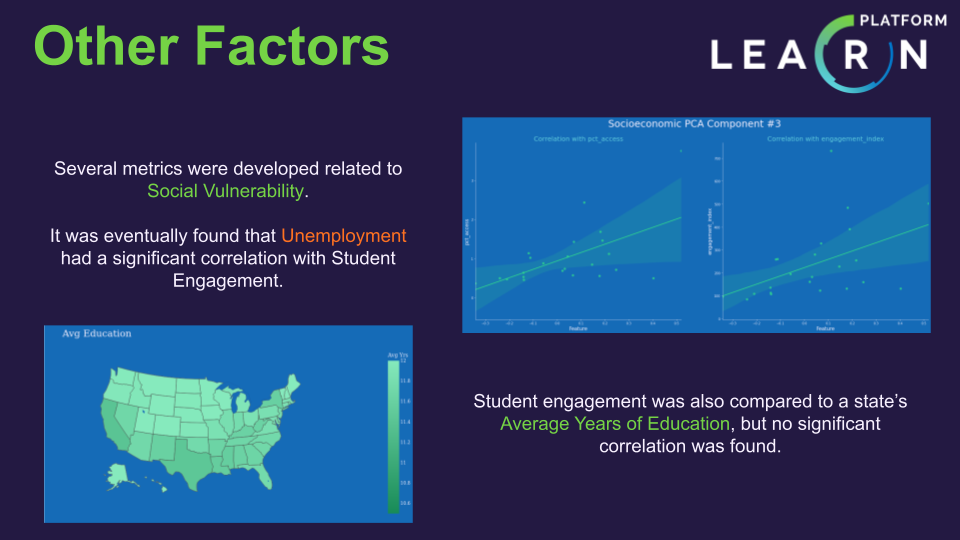

<div>
    <font size='+2' color='#0DAB6C'>
        <b>Detailed Analysis</b>
    </font>
</div>

<div>
<font size='+1'>
    To analyze the Social Vulnerability features, I used a dataset which already had categorized its features into 'Socioeconomic Status', 'Household Composition & Disability', 'Minority Status & Language' & 'Housing Type & Transportation'. Again, since there were a lot of features to handle, I used PCA to reduce dimensions till explained variance reached 70%. Shown below are the first PCA components for each category.
    <br><br>
    A similar approach can be used to understand what each of these components mean. The first PCA component for Socioeconomic factors increases with Per Capita Income & decreases with poverty rates. Hence it is clear that higher this value, the better a state is in terms of socioeconomic prosperity. The other categories, though not important, can have their first PCA component analyzed in a similar way.
</font>
</div>

In [ ]:
import numpy as np
import pandas as pd
import os
import re
import sys

import matplotlib.pyplot as plt

from scipy.stats import pearsonr

data = pd.read_csv('/kaggle/input/learnplatform-analysis-data/SVI2018_US.csv')
data = data.replace(-999, np.nan)
data = data.dropna()
data = data[data['ST_ABBR'] != 'AK'].reset_index(drop = True)

socioeconomic_cols = [
    'E_POV', 'E_UNEMP', 'E_PCI', 'E_NOHSDP', 'EP_POV',
    'EP_UNEMP', 'EP_PCI', 'EP_NOHSDP', 'EPL_UNEMP',
    'EPL_PCI', 'EPL_NOHSDP', 'SPL_THEME1', 'RPL_THEME1', 'F_POV', 'F_UNEMP', 'F_PCI', 'F_NOHSDP', 'F_THEME1',
]

household_cols = [
    'E_AGE65', 'E_AGE17', 'E_DISABL', 'E_SNGPNT', 'EP_AGE65',
    'EP_AGE17', 'EP_DISABL', 'EP_SNGPNT', 'EPL_AGE65',
    'EPL_AGE17', 'EPL_DISABL', 'EPL_SNGPNT', 'SPL_THEME2', 'RPL_THEME2', 'F_AGE65', 'F_AGE17', 'F_DISABL',
    'F_SNGPNT', 'F_THEME2',
]

minority_cols = [
    'E_MINRTY', 'E_LIMENG', 'EP_MINRTY', 'EP_LIMENG',
    'EPL_MINRTY', 'EPL_LIMENG', 'SPL_THEME3', 'RPL_THEME3', 'F_MINRTY', 'F_LIMENG', 'F_THEME3',
]

housing_cols = [
    'E_MUNIT', 'E_MOBILE', 'E_CROWD', 'E_NOVEH', 'E_GROUPQ',
    'EP_MUNIT', 'EP_MOBILE', 'EP_CROWD', 'EP_NOVEH',
    'EP_GROUPQ', 'EPL_POV', 'EPL_MUNIT', 'EPL_MOBILE', 'EPL_CROWD', 'EPL_NOVEH', 'EPL_GROUPQ',
    'SPL_THEME4', 'RPL_THEME4', 'F_MUNIT', 'F_MOBILE', 'F_CROWD', 'F_NOVEH', 'F_GROUPQ', 'F_THEME4', 'F_TOTAL',
]

# IMPORTANT:
# Alaska not considered in analysis since the extremely large area of Alaska dominates over other features

from sklearn.decomposition import PCA

social_vulnerability_metrics_names = []
social_vulnerability_metrics = []

for feat_idx, feats in enumerate([socioeconomic_cols, household_cols, minority_cols, housing_cols]):

    data_for_pca = data[feats]
    for col in data_for_pca.columns:
        data_for_pca[col] = (data_for_pca[col] - data_for_pca[col].mean()) / (data_for_pca[col].std() + 0.0000000000001)

    pca = PCA(n_components = 10)
    pca_orig_data = pca.fit_transform(data_for_pca)
    for pca_idx in range(10):
        pca_data = pca.components_[pca_idx]
        expl_var = np.sum(pca.explained_variance_ratio_[:pca_idx + 1]) * 100
        if(pca_data.sum() < 0):
            if(feat_idx not in [0]):
                pca_data = -pca_data
                social_vulnerability_metrics.append(-pca_orig_data[:, pca_idx])
            else:
                social_vulnerability_metrics.append(pca_orig_data[:, pca_idx])
        else:
            if(feat_idx in [0]):
                pca_data = -pca_data
                social_vulnerability_metrics.append(-pca_orig_data[:, pca_idx])
            else:
                social_vulnerability_metrics.append(pca_orig_data[:, pca_idx])
        
        if(feat_idx == 0):
            social_vulnerability_metrics_names.append(f'socioeconomic_{pca_idx+1}')
            col_name = "Socio-Economic Indicators"
            cats = [1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0]
        elif(feat_idx == 1):
            social_vulnerability_metrics_names.append(f'household_{pca_idx+1}')
            col_name = "Household Composition / Disability"
            cats = [1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1]
        elif(feat_idx == 2):
            social_vulnerability_metrics_names.append(f'minority_{pca_idx+1}')
            col_name = "Minority Status / Language"
            cats = [1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1]
        elif(feat_idx == 3):
            social_vulnerability_metrics_names.append(f'housing_{pca_idx+1}')
            col_name = "Housing Type / Transportation"
            cats = [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1]

        if(pca_idx == 0):
            plot_barplot(
                [x for x in feats], pca_data,
                width = 15, height = 7,
                suptitle = f"{col_name}", title = f"PCA Component {pca_idx + 1}, Explained Variance = {expl_var:.2f}%",
                xlabel = "Features", ylabel = "PCA Weight",
                rotate_x = 60,
                theme = 'DARK',
                cats = cats,
            )
        
        if(expl_var >= 70):
            break

<div>
<font size='+1'>
    The first PCA components were then plotted on the map. The main highlights are -
    <ul>
        <li>Northern US seems to be more socio-economically prosperous</li>
        <li>California seems to have much higher minority percentage</li>
        <li>New York seems to have more clustered housing with many not having vehicles</li>
    </ul>
</font>
</div>

In [ ]:
social_vulnerability_metrics = pd.DataFrame(np.asarray(social_vulnerability_metrics).transpose(), columns = social_vulnerability_metrics_names)
#print(data.shape, social_vulnerability_metrics.shape)
social_vulnerability_data = pd.concat([data[['ST_ABBR']], social_vulnerability_metrics], axis = 1)
social_vulnerability_data = social_vulnerability_data.groupby('ST_ABBR')[social_vulnerability_metrics_names].aggregate(np.nanmean).reset_index(drop = False)

plot_us_map(social_vulnerability_data, "Socioeconomic Indicators", "socioeconomic_1", "PCA Component 1", -3, 3, state_col = 'ST_ABBR', theme = 'LIGHT')
plot_us_map(social_vulnerability_data, "Household Indicators", "household_1", "PCA Component 1", -3, 3, state_col = 'ST_ABBR', theme = 'LIGHT')
plot_us_map(social_vulnerability_data, "Minority Indicators", "minority_1", "PCA Component 1", -3, 3, state_col = 'ST_ABBR', theme = 'LIGHT')
plot_us_map(social_vulnerability_data, "Housing Indicators", "housing_1", "PCA Component 1", -3, 3, state_col = 'ST_ABBR', theme = 'LIGHT')

<div>
<font size='+1'>
    Upon analyzing the correlations, it was found that the third socioeconomic PCA component had statistically significant correlation with student engagement! The PCA wights have again been plotted for the third PCA component of Socioeconomic indicators to understand why this component is highly correlated.
</font>
</div>

In [ ]:
engagement_data = DATA.groupby('state')[['pct_access', 'engagement_index']].aggregate(np.nanmean).reset_index(drop = False)
engagement_data['state'] = engagement_data['state'].replace(STATE_ABBR)

social_vulnerability_engagement_data = pd.merge(engagement_data, social_vulnerability_data, how = 'inner', left_on = 'state', right_on = 'ST_ABBR')

target_cols = ['pct_access', 'engagement_index']
corrs_table = [
    ['FEATURE', 'CORRELATION WITH PCT_ACCESS', 'CORRELATION WITH ENGAGEMENT_INDEX']
]
for col_idx, col in enumerate(social_vulnerability_metrics_names):
    row = [col]
    for target_col_idx, target_col in enumerate(target_cols):
        corr, corr_pval = pearsonr(social_vulnerability_engagement_data[target_cols[target_col_idx]], social_vulnerability_engagement_data[social_vulnerability_metrics_names[col_idx]])
        row.append(f"{corr:.2f} (pval = {corr_pval:.2f})")
    corrs_table.append(row)

from IPython.display import HTML, display
import tabulate
display(HTML(tabulate.tabulate(corrs_table, tablefmt='html')))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (25, 10))
sns.regplot(
    x = social_vulnerability_engagement_data['socioeconomic_3'],
    y = social_vulnerability_engagement_data['pct_access'],
    ax = ax[0],
    color = COLOR_GREEN,
)
sns.regplot(
    x = social_vulnerability_engagement_data['socioeconomic_3'],
    y = social_vulnerability_engagement_data['engagement_index'],
    ax = ax[1],
    color = COLOR_GREEN,
)

theme = select_theme('DARK')
for a in ax:
    fig, a = set_bg(fig, a, theme)
    a = set_ticks(a, theme)
    a = remove_spines(a, theme)
fig, ax[0] = set_titles_and_labels(fig, ax[0], "", "Correlation with pct_access", "Feature", "pct_access", theme);
fig, ax[1] = set_titles_and_labels(fig, ax[1], "Socioeconomic PCA Component #3", "Correlation with engagement_index", "Feature", "engagement_index", theme);

plt.show()

In [ ]:
data_for_pca = data[socioeconomic_cols]
for col in data_for_pca.columns:
    data_for_pca[col] = (data_for_pca[col] - data_for_pca[col].mean()) / (data_for_pca[col].std() + 0.0000000000001)

pca = PCA(n_components = 10)
pca_orig_data = pca.fit_transform(data_for_pca)
pca_idx = 2
pca_data = pca.components_[pca_idx]
expl_var = np.sum(pca.explained_variance_ratio_[:pca_idx + 1]) * 100
if(pca_data.sum() < 0):
    pca_data = -pca_data

cats = [1,0,1,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0]
plot_barplot(
    [x for x in socioeconomic_cols], pca_data,
    width = 20, height = 10,
    suptitle = f"PCA Component {pca_idx + 1} for Socioeconomic Indicators", title = "",
    xlabel = "Features", ylabel = "Weight",
    rotate_x = 60,
    theme = 'DARK',
    cats = cats,
)

<div>
<font size='+1'>
    As can be seen, unemployment and a few poverty & education related features dominate the third PCA component. Upon analyzing the individual correlations, we realize that actually unemployment was the factor which was highly correlated with student engagement.
    <br><br>
    It is also worth noting that the PCA component had more correlation than the individual features, meaning that applying PCA helped in finding the right combination of features.
</font>
</div>

In [ ]:
corr_check_cols = ['E_UNEMP', 'EPL_UNEMP', 'F_POV', 'F_PCI', 'F_NOHSDP', 'F_THEME1']
#corr_check_cols = socioeconomic_cols
grouped_data = data.groupby('ST_ABBR')[corr_check_cols].aggregate(np.nanmean).reset_index(drop = False)
data2 = pd.merge(engagement_data, grouped_data, how = 'inner', left_on = 'state', right_on = 'ST_ABBR')

target_cols = ['pct_access', 'engagement_index']
corrs_table = [
    ['FEATURE', 'CORRELATION WITH PCT_ACCESS', 'CORRELATION WITH ENGAGEMENT_INDEX']
]
for col_idx, col in enumerate(corr_check_cols):
    row = [col]
    for target_col_idx, target_col in enumerate(target_cols):
        corr, corr_pval = pearsonr(data2[target_cols[target_col_idx]], data2[corr_check_cols[col_idx]])
        row.append(f"{corr:.2f} (pval = {corr_pval:.2f})")
    corrs_table.append(row)
display(HTML(tabulate.tabulate(corrs_table, tablefmt='html')))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (25, 10))
sns.regplot(
    x = data2['E_UNEMP'],
    y = data2['pct_access'],
    ax = ax[0],
    color = COLOR_GREEN,
)
sns.regplot(
    x = data2['E_UNEMP'],
    y = data2['engagement_index'],
    ax = ax[1],
    color = COLOR_GREEN,
)

theme = select_theme('DARK')
for a in ax:
    fig, a = set_bg(fig, a, theme)
    a = set_ticks(a, theme)
    a = remove_spines(a, theme)
fig, ax[0] = set_titles_and_labels(fig, ax[0], "", "Correlation with pct_access", "Feature", "pct_access", theme);
fig, ax[1] = set_titles_and_labels(fig, ax[1], "Unemployment Feature", "Correlation with engagement_index", "Feature", "engagement_index", theme);

plt.show()

<div>
<font size='+1'>
    Finally, let us now analyze the average education in US states. The idea is that if some states seem to have more education than others, then perhaps students in such states naturally study more.
    <br><br>
    To find the average education, we use information about how much population has a high school diploma, college degree or bachelor's degree. Assuming a high school diploma requires 12 years of study, college requires 2 and Bachelor's requires 4, we can then approximate the average number of years of study for a state.
    <br><br>
    Finally, when checking for any correlation with Student Engagement, no statistically significant correlation was observed.
</font>
</div>

In [ ]:
import numpy as np
import pandas as pd
import os
import re
import sys
import time

import matplotlib.pyplot as plt

from pandas.plotting import parallel_coordinates
from scipy.stats import pearsonr

data = pd.read_excel('/kaggle/input/learnplatform-analysis-data/Education (copy).xls')

latest_2015_19_total_cols = [
    'Less than a high school diploma, 2015-19',
    'High school diploma only, 2015-19',
    "Some college or associate's degree, 2015-19",
    "Bachelor's degree or higher, 2015-19",
]

latest_data = data.groupby('State')[latest_2015_19_total_cols].aggregate(np.sum).reset_index(drop = False)
# latest_data['Total'] = latest_data.apply(lambda x: np.sum([x[y] for y in latest_2015_19_total_cols]), axis = 1)

# HS = HS only + C/A + B = HS only + C/A + ~0.7 * HS
# HS = (HS only + C/A) / ~0.3
# REFERENCE: https://educationdata.org/college-enrollment-statistics

latest_data['has no High School Diploma'] = latest_data['Less than a high school diploma, 2015-19']
latest_data['has High School Diploma only'] = latest_data['High school diploma only, 2015-19']
latest_data['has College/Associate Degree'] = latest_data['Some college or associate\'s degree, 2015-19']
latest_data['has Bachelors Degree'] = latest_data['Bachelor\'s degree or higher, 2015-19']
latest_data['has High School Diploma'] = latest_data.apply(lambda x: (x['has High School Diploma only'] + x['has College/Associate Degree']) / 0.3, axis = 1)

use_cols = ['State', 'has no High School Diploma', 'has High School Diploma', 'has College/Associate Degree', 'has Bachelors Degree']
latest_data = latest_data[use_cols]
latest_data['Total People'] = latest_data['has no High School Diploma'] + latest_data['has High School Diploma']

for col in use_cols[1:]:
    latest_data[col] = latest_data[col] / latest_data['Total People']

latest_data['Avg Yrs of Study'] = (
    latest_data['has no High School Diploma'] * 0 +
    latest_data['has High School Diploma'] * 12 +
    latest_data['has College/Associate Degree'] * 2 +
    latest_data['has Bachelors Degree'] * 4
)

engagement_data = DATA.groupby('state')[['pct_access', 'engagement_index']].aggregate(np.nanmean).reset_index(drop = False)
engagement_data['state'] = engagement_data['state'].replace(STATE_ABBR)

education_engagement_data = pd.merge(engagement_data, latest_data, how = 'inner', left_on = 'state', right_on = 'State')
corr, corr_pval = pearsonr(education_engagement_data['engagement_index'], education_engagement_data['Avg Yrs of Study'])

plot_us_map(latest_data, f"Average Education: Correlation={corr:.2f}, pval={corr_pval:.2f}", "Avg Yrs of Study", "Avg Yrs", 10, 12.5, state_col = 'State', theme = 'DARK')

<div style="background-color: #F8F1FF; padding: 20px 50px;">
<span style="color:#156BB7;">
<font size='+2.5'>
    <b>9 PM:</b>
</font>
<br>
<br>
<font size='+1.5'>
    Little Grace is sleeping in her bedroom now. In a single day, she has inadvertently given so many ideas to think about. She has made me realize that a child's mind works in ways much different than an adult. People like me have spent years to understand what we speak and do. But curious little minds like her make no hesitation in tackling fundamental issues which we arrogant adults miss.
    <br><br>
    Which is why it becomes so important to ensure that their innocent curiousness today translates into revolutionary breakthroughs tomorrow. Every organization involved in the Education sector strives to make sure that students do not miss out on the education that would propel them to much greater heights tomorrow. In a world where people are still being divided on several basis, it is important that Education stays united in front of all students.
    <br><br>
    <b>This is why Educational Equity is not an option, it is an essential.</b>
</font>
</span>
</div>

<div>
<font size='+1'>
    Now let me go to sleep before my wife realizes I forgot to take the garbage out...
</font>
</div>

# Thank You!
## Analysis by Sakshat Rao

<div>
    <font size='+2' color='#0DAB6C'>
        <b>References</b>
    </font>
</div>

### Data Sources
1. Oxford Covid-19 Government Response Tracker (OxCGRT) - https://www.kaggle.com/ruchi798/oxford-covid19-government-response-tracker & https://www.nature.com/articles/s41562-021-01079-8
2. Educational attainment for the U.S. - https://www.ers.usda.gov/webdocs/DataFiles/48747/Education.xls?v=4171.5
3. Broadband Access - https://www.imls.gov/data/data-catalog/imls-indicators-workbook-economic-status-and-broadband-availability-and-adoption, https://github.com/BroadbandNow/Open-Data
4. EdWeek School Reopening - https://www.edweek.org/leadership/map-where-are-schools-closed/2020/07
5. US State Population - https://www.census.gov/programs-surveys/popest/technical-documentation/research/evaluation-estimates/2020-evaluation-estimates/2010s-state-total.html
6. US State Area - https://www.census.gov/geographies/reference-files/2010/geo/state-area.html
7. US State Polygons - https://www2.census.gov/geo/tiger/TIGER2020/STATE/
8. US States - Red/Blue - https://en.wikipedia.org/wiki/2020_United_States_presidential_election#cite_note-FEC-7
9. COVID-19 US State Policy database - https://en.wikipedia.org/wiki/2020_United_States_presidential_election#cite_note-FEC-7
10. ACS 1-Year Estimates Data Profiles - https://data.census.gov/cedsci/table?d=ACS 1-Year Estimates Data Profiles&tid=ACSDP1Y2019.DP02&hidePreview=false


### References
1. https://www.kaggle.com/dmitryuarov/eda-covid-19-impact-on-digital-learning
2. https://educationdata.org/college-enrollment-statistics
3. https://www.reneshbedre.com/blog/anova.html
4. https://towardsdatascience.com/exploratory-spatial-data-analysis-esda-spatial-autocorrelation-7592edcbef9a
5. https://www.geeksforgeeks.org/how-to-plot-andrews-curves-using-pandas-in-python/
6. https://wenr.wes.org/2018/06/education-in-the-united-states-of-america
7. https://educationdata.org/college-enrollment-statistics
8. https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/
9. https://www.similarweb.com/
10. https://www.python-graph-gallery.com/
11. https://github.com/BroadbandNow/Open-Data
12. https://www.worldbank.org/en/topic/edutech/brief/how-countries-are-using-edtech-to-support-remote-learning-during-the-covid-19-pandemic
13. https://splot.readthedocs.io/en/stable/users/tutorials/autocorrelation.html
14. https://www.edweek.org/